# NATURAL GAS
In the last few years prices of natural resources, such as gas, have skyrocketed. The impact in the Netherlands, as in many other countries, is huge and therefore a good subject to use for a new data science project! We will be exploring historic data to try and understand what is happening and try to explain what decisions and changes have led to where we are now.

## DATA
In the Netherlands we have the Central Bureau of Statistics ([CBS](https://www.cbs.nl)). They provide insights into many topics such as unemployment rates, greenhouse gas emissions, inflation, house pricing, supply and demand of natural gas, and many more. In addition to writing very informative articles (based on facts), they also give open access to the data used for the articles, such as this one: [Natural gas consumption 25 percent lower in first half of 2022](https://www.cbs.nl/en-gb/news/2022/35/natural-gas-consumption-25-percent-lower-in-first-half-of-2022) ([link to data](https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=00372eng&_theme=1053)).

## TOOLS
For this project we will be making use of [Python](https://www.python.org/), [Jupyter](https://jupyter.org/), [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/), [Seaborn](https://seaborn.pydata.org/), and [many more](https://pypi.org/). A full list can be found in the requirements.txt file of the [repository](https://github.com/michaelvanvliet/natural-gas-supply-and-consumption)

DISCLAIMER: All information in this document is based on my own opinion and I'm not an expert on natural gas production and/or consumption!

In [1]:
# import required logic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import requests
import json

In [2]:
##############################################################################
# settings
##############################################################################
odata_index_url = "https://opendata.cbs.nl/ODataApi/odata/00372eng"

# sns
sns.set(rc={"figure.figsize": (15, 5)})

In [3]:
##############################################################################
# fetch data
##############################################################################

# read index
odata_index = json.loads(requests.get(odata_index_url).text)

# read data files
data = {}
for data_file in odata_index["value"]:
    data[data_file["name"]] = json.loads(
        requests.get(data_file["url"]).text
    )

# keep only the required information...
summary = data["TableInfos"]
description = pd.DataFrame(data["DataProperties"]["value"])
df = pd.DataFrame(data["TypedDataSet"]["value"])

# ... and delete the rest
del data

##############################################################################
# data wrangling
##############################################################################

# turn into a data dictionary
description = description[description["Key"] != ""]
data_dictionary = description.set_index("Key")
data_dictionary = data_dictionary[
    [
        "Title",
        "Description",
        "Unit",
    ]
].to_dict("index")

##############################################################################
### df (dataframe)

df = df.fillna(0)  # replace null with zeros

# keep only the monthly records
df = df[df["Periods"].str.contains("MM")]

# create year, month, day column, and generate a date column (index)
df["Year"] = df["Periods"].apply(lambda x: int(x[0:4]))
df["Month"] = df["Periods"].apply(lambda x: int(x[6:9]))
df["MonthLabel"] = df["Month"].apply(lambda x: calendar.month_abbr[x])
df["Day"] = 1  # although it should probably be the last day of the month
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

df["import"] = (  # create totals for import
    df["ImportsOfGaseousNaturalGas_4"] + \
        df["ImportsOfLiquefiedNaturalGasLng_5"]
)

df["export"] = (  # create totals for export
    df["ExportsOfGaseousNaturalGas_6"] + \
        df["ExportsOfLiquefiedNaturalGasLng_7"]
)

# product total
df["production"] = df["IndigenousProduction_2"] + \
    df["ProductionFromOtherSources_3"]

# total consumption (better label)
df["consumption"] = df["TotalConsumption_10"]

# in/out
df["in"] = df["import"] + df["production"]
df["out"] = df["export"] + df["consumption"]

# filter data to be limit to this century
# df = df[df['Year'] >= 1996]

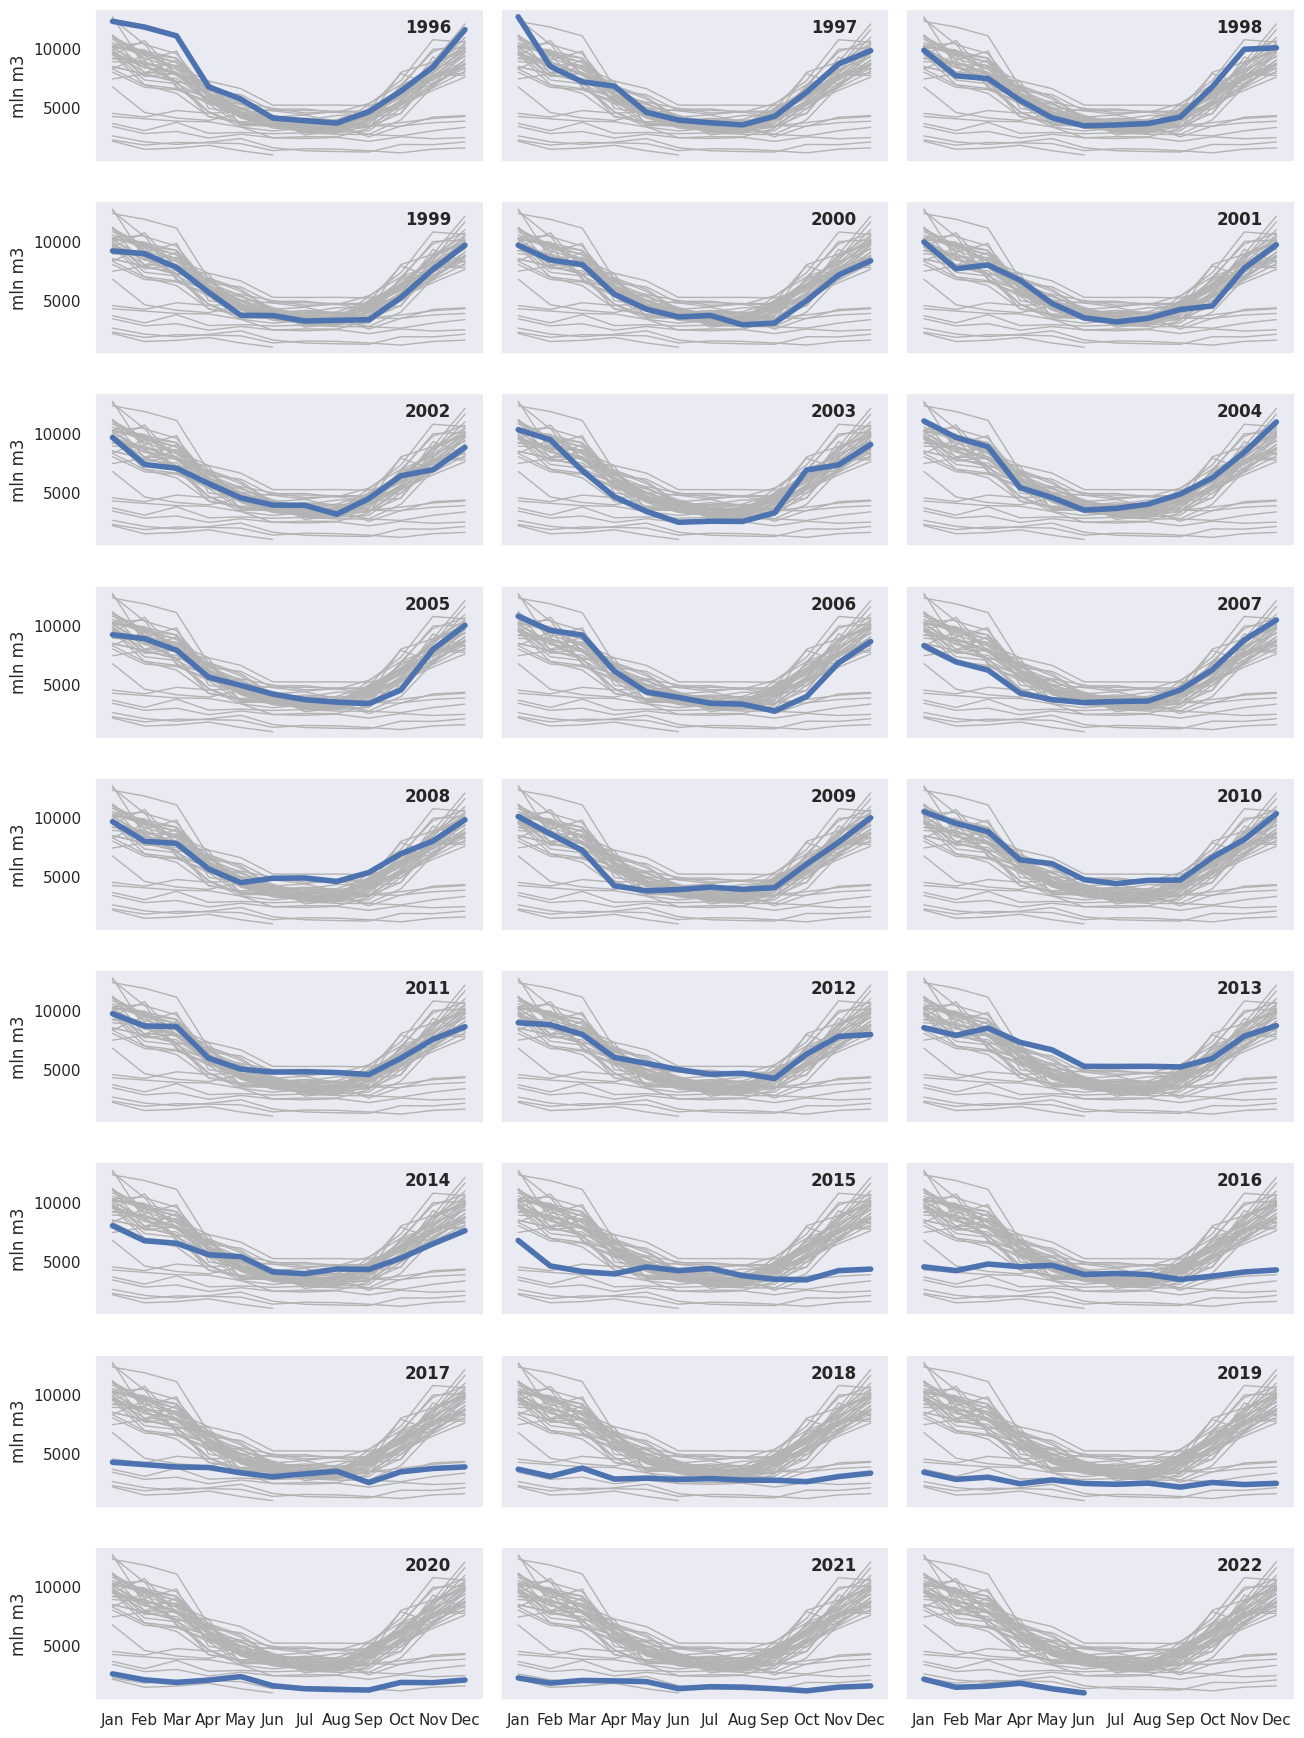

In [4]:
sns.set_theme(style="dark")

##############################################################################
# PLOTS
##############################################################################

# set unit label for gas volumes
gas_volume_units = data_dictionary["IndigenousProduction_2"]["Unit"]

# Natural gas production by year
g = sns.relplot(
    data=df.query("IndigenousProduction_2 >= 0 and Year >= 1996"),
    x="MonthLabel",
    y="IndigenousProduction_2",
    col="Year",
    kind="line",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=2.2,
    legend=True,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():
    ax.text(0.8, 0.85, year, transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=df,
        x="MonthLabel",
        y="IndigenousProduction_2",
        units="Year",
        estimator=None,
        color=".7",
        linewidth=1,
        ax=ax,
    )

g.set_titles("")
# g.fig.suptitle(data_dictionary["IndigenousProduction_2"]['Title'])
g.set_axis_labels("", gas_volume_units)

plt.show()

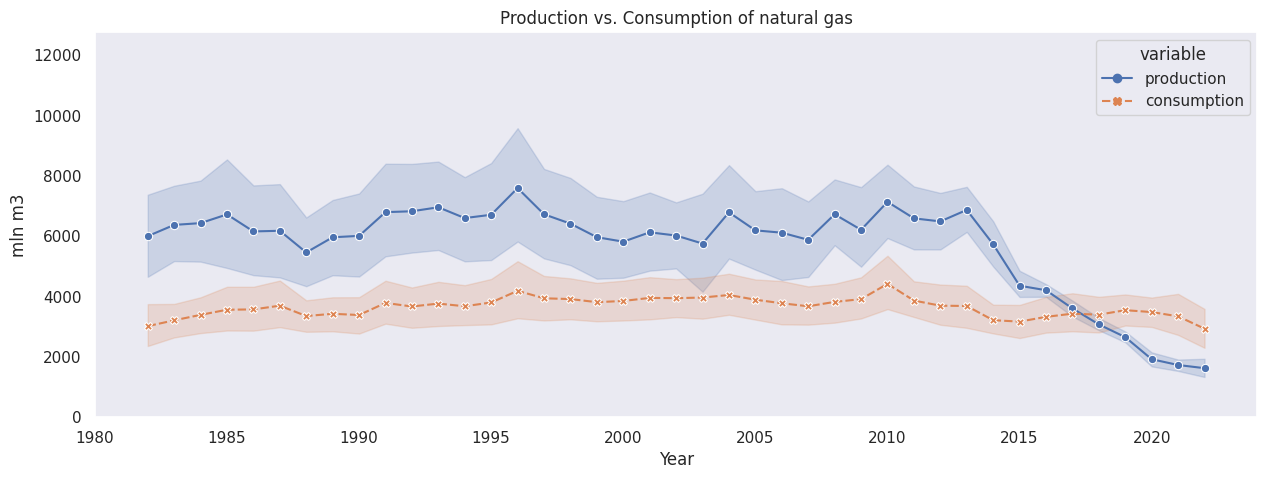

In [5]:
##############################################################################
# production / consumption
production_consumption_df = pd.melt(  # set data
    df, id_vars=["Year"], value_vars=["production", "consumption"]
)

sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=production_consumption_df,
)

# layout
plt.ylim(0, production_consumption_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Production vs. Consumption of natural gas")
plt.show()

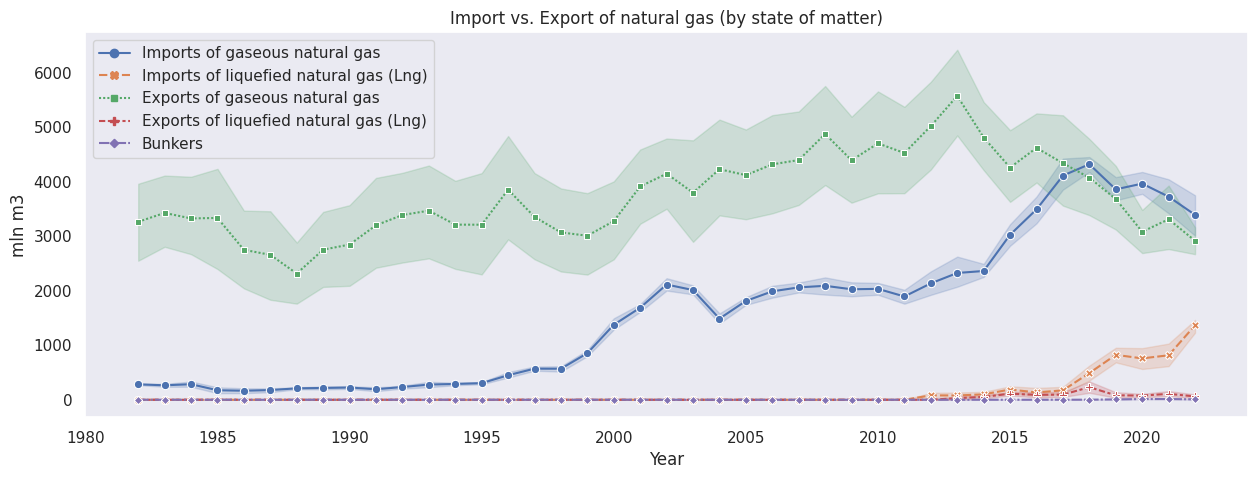

Imports of gaseous natural gas: Imports of gaseous natural gas through cross border pipelines.
Imports of liquefied natural gas (Lng): Imports of liquefied natural gas (Lng).
The gas is liquefied through cooling till about minus 160 degrees Celsius. This makes transport in ships over long distances possible.
Exports of gaseous natural gas: Exports of gaseous natural gas through cross border pipelines.
Exports of liquefied natural gas (Lng): Exports of liquefied natural gas (Lng).
The gas is liquefied through cooling till about minus 160 degrees Celsius. This makes transport in ships over long distances possible.
Bunkers: Delivery of fuels for international shipping and aviation, i.e. ships and aircraft departing from Dutch (air)ports and arriving in foreign (air)ports. Bunkers are considered as a form of export and are not included in energy available for consumption in the Netherlands.


In [6]:
##############################################################################
# import vs export by state

import_export_state_df = pd.melt(  # set data
    df,
    id_vars=["Year"],
    value_vars=[
        "ImportsOfGaseousNaturalGas_4",
        "ImportsOfLiquefiedNaturalGasLng_5",
        "ExportsOfGaseousNaturalGas_6",
        "ExportsOfLiquefiedNaturalGasLng_7",
        "Bunkers_8"
    ],
)

# Gas import/export
ie = sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=import_export_state_df,
)

# layout
handles, labels = ie.get_legend_handles_labels()
ie.legend(
    handles,
    [data_dictionary[l]["Title"] for l in labels],
    loc="upper left"
)

plt.ylabel(gas_volume_units)
plt.title("Import vs. Export of natural gas (by state of matter)")
plt.show()

for l in labels:
    print(f"{data_dictionary[l]['Title']}: {data_dictionary[l]['Description']}")

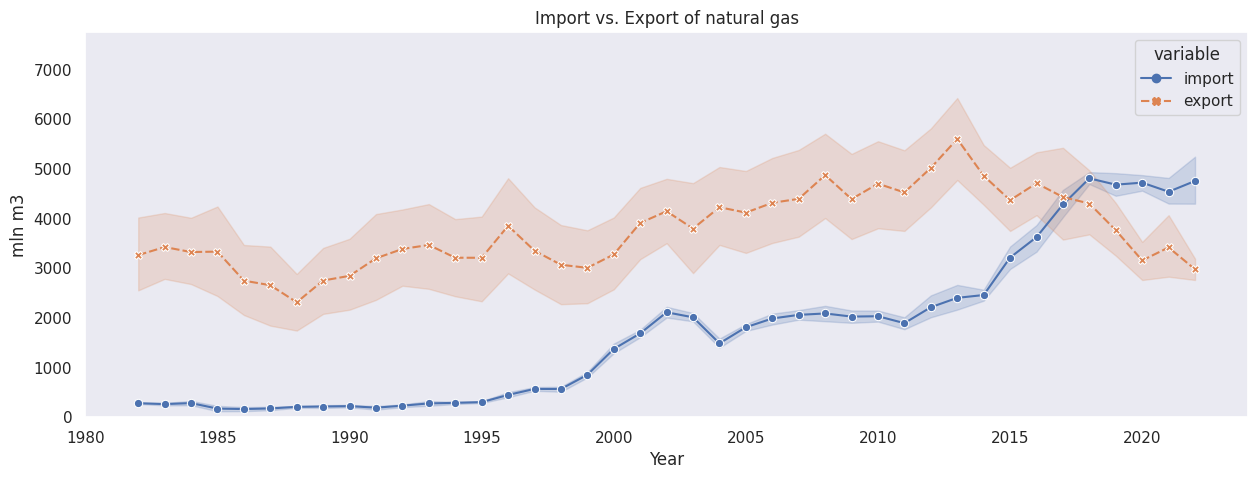

In [7]:
##############################################################################
# import / export
import_export_df = pd.melt(  # set data
    df, id_vars=["Year"], value_vars=["import", "export"]
)

sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=import_export_df,
)

# layout
plt.ylim(0, import_export_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Import vs. Export of natural gas")
plt.show()

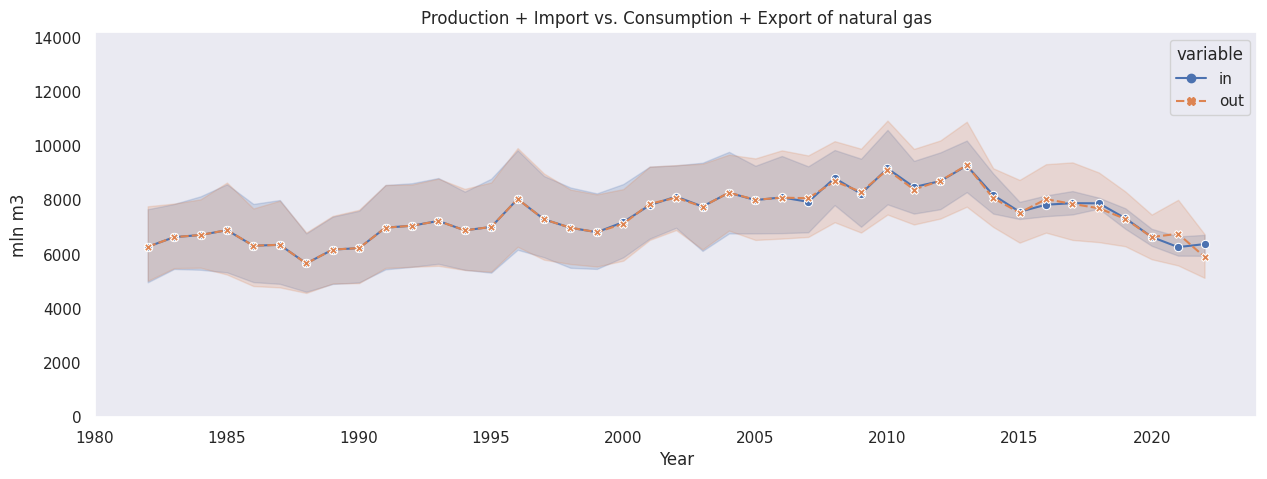

In [8]:
##############################################################################
# in / out
in_out_df = pd.melt( # set data
    df, id_vars=["Year"], value_vars=["in", "out"]
)

sns.lineplot(
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=in_out_df
)

plt.ylim(0, in_out_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Production + Import vs. Consumption + Export of natural gas")
plt.show()

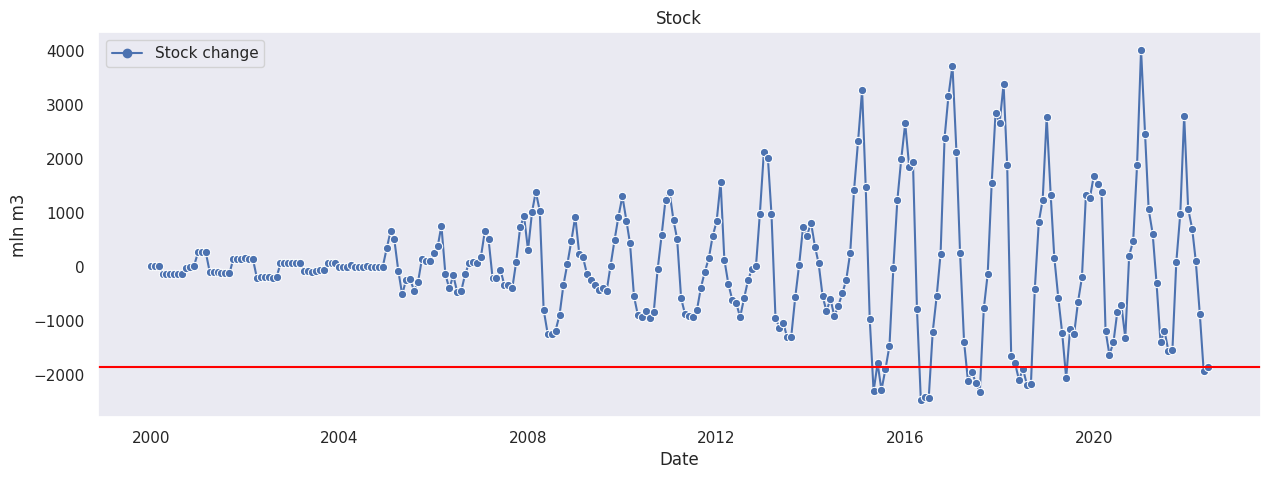

Stock change: Stock change of natural gas in underground storages and stock changes of liquefied natural gas (Lng). Includes also small changes in the emergency supply of natural gas and in the natural gas pipelines. During extremely cold weather the emergency supply is used to keep the natural gas supply at the normal level. During hot weather the emergency supply is supplemented again. The change of stock is calculated as the opening stock minus the closing stock, in accordance with international energy statistics guidelines. A positive figure means that the stock has decreased, and the supply of natural gas has thus increased. A negative figure means the opposite: an increase in stock and decrease in consumption.



In [9]:
##############################################################################
# stock

stock_df = pd.melt(  # set data
    df.query("Year >= 2000"),
    id_vars=["Date"],
    value_vars=[
        "StockChange_9"
    ],
)

# Stock in the Netherlands
stock = sns.lineplot(  # plot
    x="Date",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=stock_df,
)

# add line of current value
current_stock = stock_df.iloc[-1]['value']
stock.axhline(current_stock, color="red")

# layout
handles, labels = stock.get_legend_handles_labels()
stock.legend(
    handles,
    [data_dictionary[l]["Title"] for l in labels],
    loc="upper left"
)

plt.ylabel(gas_volume_units)
plt.title("Stock")
plt.show()

for l in labels:
    print(f"{data_dictionary[l]['Title']}: {data_dictionary[l]['Description']}")